In [1]:
!pip install -U pillow


In [2]:
!pip install ultralytics --quiet


In [3]:
!pip install pillow opencv-python-headless --quiet


In [4]:
from ultralytics import YOLO
print("Ultralytics imported successfully!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics imported successfully!


In [5]:
# This cell creates /content/ts_dataset with images & segmentation labels (YOLO polygon format).
import os, random, math, shutil, json, cv2, sys
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import numpy as np

ROOT = "/content/ts_dataset"
IMG_TRAIN = f"{ROOT}/images/train"
IMG_VAL   = f"{ROOT}/images/val"
LBL_TRAIN = f"{ROOT}/labels/train"
LBL_VAL   = f"{ROOT}/labels/val"

# create folders
for d in [IMG_TRAIN, IMG_VAL, LBL_TRAIN, LBL_VAL]:
    os.makedirs(d, exist_ok=True)

# ----- helper: create sign template (Pillow textbbox-safe) -----
def make_sign(text, shape="circle", size=128, color=(220,20,60)):
    img = Image.new("RGBA", (size, size), (0,0,0,0))
    draw = ImageDraw.Draw(img)
    pad = int(size * 0.08)
    if shape == "circle":
        draw.ellipse((pad,pad,size-pad,size-pad), fill=color+(255,))
    elif shape == "triangle":
        draw.polygon([(size/2,pad),(size-pad,size-pad),(pad,size-pad)], fill=color+(255,))
    elif shape == "rect":
        draw.rectangle((pad, int(size*0.18), size-pad, size-int(size*0.18)), fill=color+(255,))

    # load a font (fallback to default)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", int(size*0.28))
    except:
        font = ImageFont.load_default()

    bbox = draw.textbbox((0,0), text, font=font)
    tw = bbox[2] - bbox[0]
    th = bbox[3] - bbox[1]
    draw.text(((size-tw)/2,(size-th)/2), text, fill=(255,255,255,255), font=font)
    return img

# templates (5 classes)
TEMPLATES = {
    0: make_sign("50","circle",size=160, color=(220,20,60)),   # speed_limit
    1: make_sign("STOP","rect",size=160, color=(180,0,0)),     # stop
    2: make_sign("<","rect",size=140, color=(0,130,200)),      # direction_left
    3: make_sign(">","rect",size=140, color=(0,130,200)),      # direction_right
    4: make_sign("!","triangle",size=160, color=(210,140,0)),  # warning_triangle
}

# helper: make synthetic background
def make_bg(w=640,h=640):
    arr = np.zeros((h,w,3), dtype=np.uint8)
    for y in range(h):
        val = int(90 + 60 * (y / h)) + random.randint(-10,10)
        arr[y,:,:] = np.clip(val + np.random.randint(-5,5,size=3), 30, 240)
    img = Image.fromarray(arr).filter(ImageFilter.GaussianBlur(radius=1.2))
    return img

# helper: place sign with random transforms and produce binary mask
def place_sign_on_bg(bg, template):
    # template: PIL RGBA
    tw, th = template.size
    # random scale
    scale = random.uniform(0.25, 0.55)
    nw = max(20, int(tw * scale))
    nh = max(20, int(th * scale))
    tpl = template.resize((nw, nh), Image.LANCZOS)

    # optionally rotate small angle
    angle = random.uniform(-12, 12)
    tpl = tpl.rotate(angle, resample=Image.BICUBIC, expand=True)

    # optional perspective: small affine by random jitter
    # We'll do a simple affine shear/translate to keep it stable
    arr = np.array(tpl)
    h,w = tpl.size[1], tpl.size[0]
    # pick position avoiding bottom center heavily
    W,H = bg.size
    attempts = 0
    while True:
        x = random.randint(0, max(0, W - w))
        y = random.randint(0, max(0, H - h))
        # avoid bottom-center road-like area
        if not (x > W*0.28 and x < W*0.72 and y > H*0.6):
            break
        attempts += 1
        if attempts > 50:
            break

    # composite
    bg.paste(tpl, (x,y), tpl)

    # make mask from alpha channel
    alpha = np.array(tpl.split()[-1])
    mask = np.zeros((bg.size[1], bg.size[0]), dtype=np.uint8)
    mask[y:y+alpha.shape[0], x:x+alpha.shape[1]] = (alpha > 10).astype(np.uint8) * 255

    # optionally blur mask edges slightly
    mask = cv2.medianBlur(mask, 3)
    return mask, (x,y,w,h)

# helper: convert binary mask -> polygon (approximate, simplify)
def mask_to_polygon(mask, max_points=80, epsilon_ratio=0.01):
    # find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polys = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:  # skip tiny
            continue
        # approximate polygon to reduce points
        peri = cv2.arcLength(cnt, True)
        eps = max(1.0, epsilon_ratio * peri)
        approx = cv2.approxPolyDP(cnt, eps, True)
        if len(approx) < 3:
            continue
        poly = approx.reshape(-1,2).tolist()
        if len(poly) > max_points:
            # further reduce by resampling evenly
            step = int(math.ceil(len(poly)/max_points))
            poly = poly[::step]
        # flatten
        flat = [coord for point in poly for coord in point]
        polys.append(flat)
    return polys  # list of polygons (each flattened [x1,y1,x2,y2,...])

# generate dataset images + labels (YOLOv8 segmentation polygon format)
def generate_dataset(n_train=300, n_val=50, img_size=640, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    id_counter = 0

    def make_and_save(i, split):
        nonlocal id_counter
        bg = make_bg(img_size, img_size)
        masks_combined = np.zeros((img_size, img_size), dtype=np.uint8)
        objects = []  # list of tuples (class_id, polygon)

        # randomly place 2-4 signs
        for _ in range(random.randint(2,4)):
            cid = random.choice(list(TEMPLATES.keys()))
            mask, bbox = place_sign_on_bg(bg, TEMPLATES[cid])
            # add mask to combined with unique label per object (not strictly needed)
            # extract polygons from mask region
            polys = mask_to_polygon(mask)
            for poly in polys:
                # poly is list of x,y in absolute pixels
                # turn to normalized x,y fractional coordinates for YOLO segmentation format
                if len(poly) < 6:  # need at least 3 points
                    continue
                norm = []
                for idx in range(0, len(poly), 2):
                    nx = poly[idx] / img_size
                    ny = poly[idx+1] / img_size
                    # clamp
                    nx = min(max(nx, 0.0), 1.0)
                    ny = min(max(ny, 0.0), 1.0)
                    norm.extend([nx, ny])
                # skip degenerate polys
                if len(norm) < 6:
                    continue
                objects.append((cid, norm))

        # if no objects (very unlikely), place one forcibly
        if len(objects) == 0:
            cid = 0
            mask, _ = place_sign_on_bg(bg, TEMPLATES[cid])
            polys = mask_to_polygon(mask)
            for poly in polys:
                norm=[]
                for idx in range(0, len(poly), 2):
                    norm.extend([poly[idx]/img_size, poly[idx+1]/img_size])
                if len(norm) >= 6:
                    objects.append((cid,norm))
                    break

        # save image
        fname = f"{id_counter:06d}.jpg"
        if split == "train":
            img_path = os.path.join(IMG_TRAIN, fname)
            lbl_path = os.path.join(LBL_TRAIN, f"{id_counter:06d}.txt")
        else:
            img_path = os.path.join(IMG_VAL, fname)
            lbl_path = os.path.join(LBL_VAL, f"{id_counter:06d}.txt")

        bg.convert("RGB").save(img_path, quality=90)

        # save label file (one line per object):
        # class_id x1 y1 x2 y2 x3 y3 ...
        with open(lbl_path, "w") as f:
            for cid, norm_poly in objects:
                # YOLO expects floats space separated
                line = str(cid) + " " + " ".join([f"{v:.6f}" for v in norm_poly])
                f.write(line + "\n")

        id_counter += 1

    # generate train
    for i in range(n_train):
        make_and_save(i, "train")
    # generate val
    for i in range(n_val):
        make_and_save(i + n_train, "val")

    print(f"Created dataset: {n_train} train, {n_val} val at {ROOT}")

# create dataset
generate_dataset(n_train=300, n_val=50, img_size=640)

# create data.yaml
data_yaml = {
    "train": os.path.abspath(IMG_TRAIN),
    "val": os.path.abspath(IMG_VAL),
    "nc": 5,
    "names": ["speed_limit","stop","direction_left","direction_right","warning_triangle"]
}
with open(os.path.join(ROOT,"data.yaml"), "w") as f:
    import yaml
    yaml.dump(data_yaml, f)

print("data.yaml created at", os.path.join(ROOT,"data.yaml"))


Created dataset: 300 train, 50 val at /content/ts_dataset
data.yaml created at /content/ts_dataset/data.yaml


Image: /content/ts_dataset/images/train/000162.jpg
Label contents:
1 0.682813 0.621875 0.579688 0.623437 0.579688 0.701562 0.682813 0.700000
1 0.132812 0.726562 0.126562 0.806250 0.229687 0.815625 0.237500 0.735938


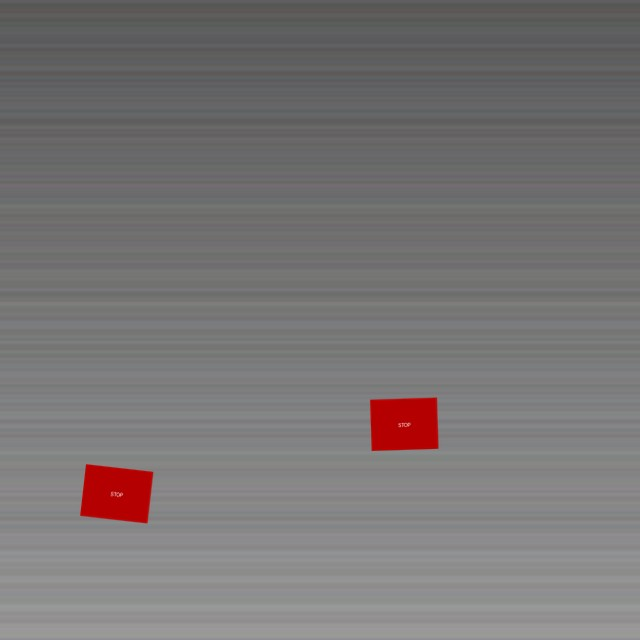

Image: /content/ts_dataset/images/train/000186.jpg
Label contents:
2 0.429688 0.084375 0.421875 0.132812 0.484375 0.142187 0.492188 0.093750
0 0.048438 0.625000 0.034375 0.637500 0.029687 0.646875 0.031250 0.667188 0.037500 0.676562 0.048438 0.684375 0.057813 0.687500 0.075000 0.684375 0.087500 0.673438 0.092188 0.664062 0.092188 0.645312 0.082812 0.631250 0.068750 0.623437


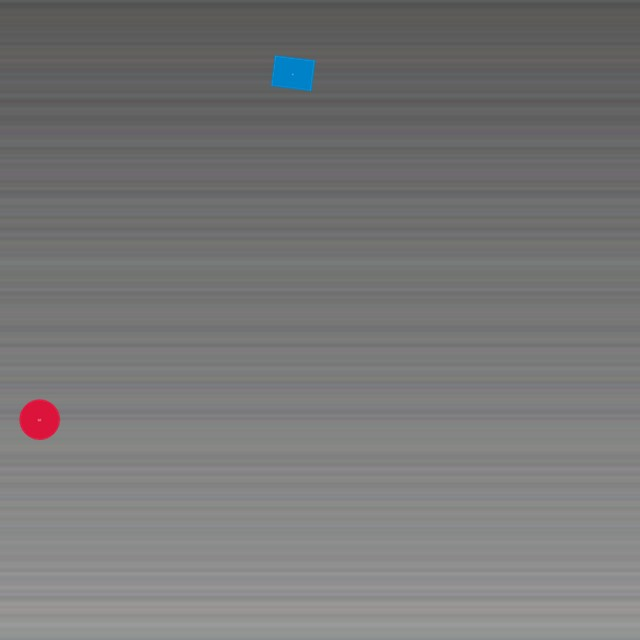

Image: /content/ts_dataset/images/train/000295.jpg
Label contents:
3 0.523438 0.473438 0.517188 0.539062 0.604688 0.546875 0.609375 0.481250
0 0.620313 0.535937 0.604688 0.542188 0.587500 0.557813 0.579688 0.578125 0.579688 0.596875 0.598437 0.626563 0.618750 0.635938 0.637500 0.637500 0.656250 0.629687 0.671875 0.615625 0.681250 0.579688 0.662500 0.546875 0.645312 0.537500
2 0.585938 0.412500 0.578125 0.470313 0.581250 0.475000 0.662500 0.482812 0.668750 0.420312
2 0.026562 0.232813 0.023438 0.292187 0.101562 0.295312 0.104688 0.235937


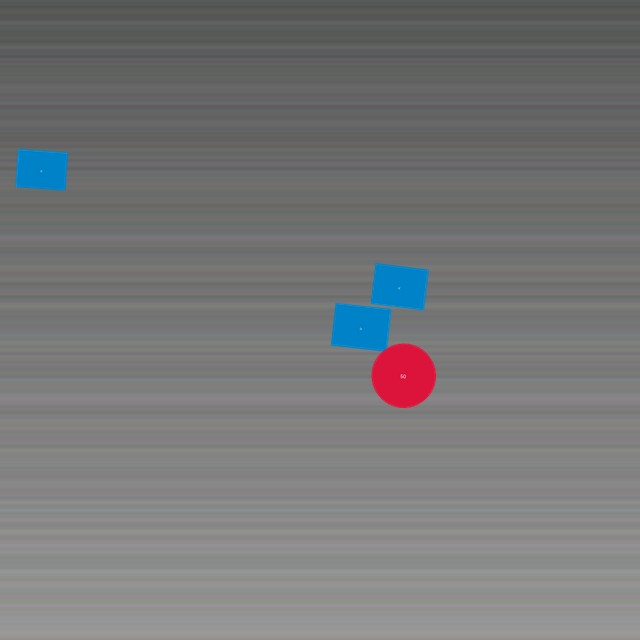

Image: /content/ts_dataset/images/train/000131.jpg
Label contents:
1 0.134375 0.343750 0.120313 0.407813 0.204687 0.425000 0.218750 0.360938
0 0.829688 0.660937 0.810937 0.675000 0.806250 0.693750 0.812500 0.707812 0.823438 0.718750 0.842187 0.721875 0.862500 0.709375 0.867188 0.700000 0.868750 0.685937 0.862500 0.673438 0.853125 0.664062 0.845313 0.660937
4 0.676562 0.390625 0.631250 0.451562 0.698438 0.465625


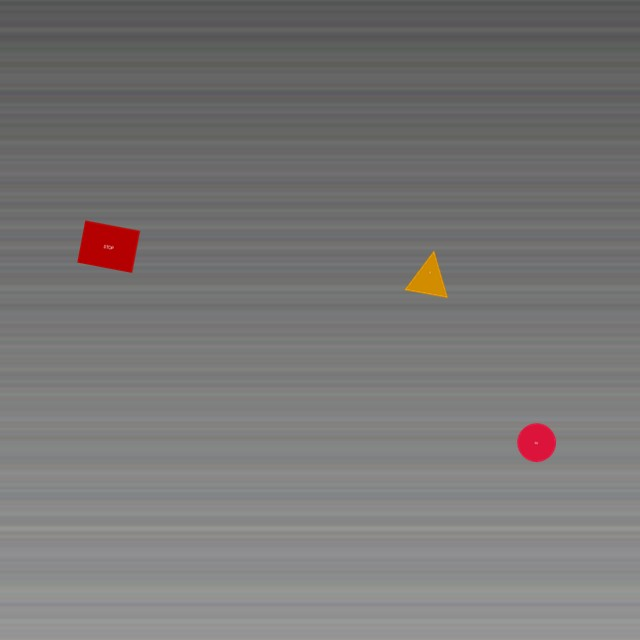

In [6]:
# Visualize a couple examples and print label lines
from IPython.display import Image as IPyImage, display
import glob
img_files = glob.glob("/content/ts_dataset/images/train/*.jpg")[:4]
for p in img_files:
    print("Image:", p)
    txt = p.replace("/images/", "/labels/").replace(".jpg", ".txt")
    print("Label contents:")
    with open(txt, "r") as f:
        print(f.read().strip())
    display(IPyImage(filename=p, width=400))


In [7]:
# If you have GPU, training will be faster. Adjust epochs and batch size to fit runtime.
from ultralytics import YOLO

model = YOLO("yolov8m-seg.pt")  # downloaded automatically first time

# NOTE:
# - epochs: increase (50-200) for better results
# - batch: set lower if OOM; use batch=8 or 4 on Colab GPUs
# - imgsz: 640 is OK
model.train(
    data="/content/ts_dataset/data.yaml",
    epochs=30,
    imgsz=640,
    batch=4,
    device=0  # use GPU: 0. If you want CPU, set device='cpu'
)


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ts_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa3680859d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,  

Running inference on: /content/ts_dataset/images/val/000313.jpg

image 1/1 /content/ts_dataset/images/val/000313.jpg: 640x640 1 stop, 1 direction_left, 1 direction_right, 2 warning_triangles, 45.6ms
Speed: 1.8ms preprocess, 45.6ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)


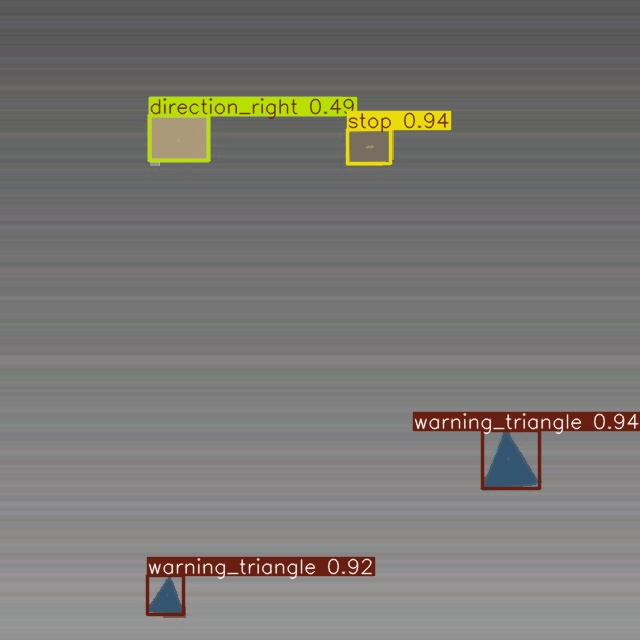

In [8]:
from ultralytics import YOLO
import cv2, glob
from IPython.display import display, Image as IPyImage

# load best weights produced by training
weights = "/content/runs/segment/train/weights/best.pt"  # typical Ultralytics path
model = YOLO(weights)

# pick a val image
val_imgs = glob.glob("/content/ts_dataset/images/val/*.jpg")
if len(val_imgs)==0:
    print("No val images found.")
else:
    imgp = val_imgs[0]
    print("Running inference on:", imgp)
    results = model.predict(imgp, save=False, imgsz=640)[0]
    # results.plot() returns an OpenCV BGR image
    out_img = results.plot()
    # save and display
    out_path = "/content/ts_dataset/inference_result.jpg"
    cv2.imwrite(out_path, out_img[:,:,::-1])  # plot() returns RGB; cv2.imwrite needs BGR
    display(IPyImage(filename=out_path, width=600))


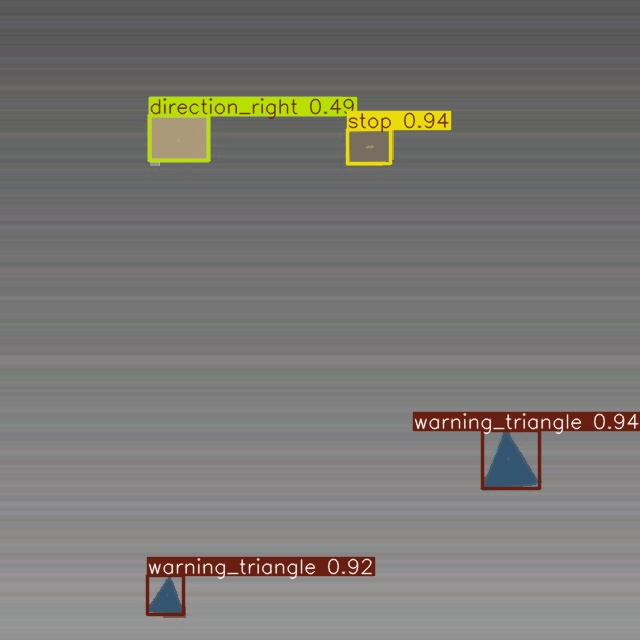

In [9]:
display(IPyImage(filename=out_path, width=600))

